# Clusterisation

## Preprocessing

On s'inspire ici largement de la méthode de clusterisation vue en cours.

In [1]:
import pandas as pd
from _jointure_validations_stations import df_jointure_validations_stations
import matplotlib.pyplot as plt
from _pre_proces_stations import df_stations
import seaborn as sns

data=df_jointure_validations_stations()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [2]:
data.shape

(204317, 74)

In [3]:
import numpy as np 

data_clustering = data.drop(
    ['lda', 'Année', 'Geo Point', 'Geo Shape', 'id_ref_ZdC', 'nom_ZdC', 'id_ref_ZdA', 'gares_id', 'x', 'y', 'idrefliga', 'idrefligc', 'indice_lig'],
    axis=1
).dropna(
    axis=1, how='all' 
).select_dtypes(
    include=np.number
)

data_clustering

,NB_VALD,Mois,lignes,bus_jour,noctilien,idf,principal,index_right,i_est_1km,ind,...,ind_25_39,ind_40_54,ind_55_64,ind_65_79,ind_80p,ind_inc,pre_IDF,select,expt,
0,55,1,2,16,2,1,0,13715.0,0.0,9075.5,...,2106.0,1697.0,902.9,619.1,92.0,46.0,1.0,1.0,1.0,NaN
1,32,1,2,16,2,1,0,13715.0,0.0,9075.5,...,2106.0,1697.0,902.9,619.1,92.0,46.0,1.0,1.0,1.0,NaN
2,93,1,2,16,2,1,0,13715.0,0.0,9075.5,...,2106.0,1697.0,902.9,619.1,92.0,46.0,1.0,1.0,1.0,NaN
3,316,1,2,16,2,1,0,13715.0,0.0,9075.5,...,2106.0,1697.0,902.9,619.1,92.0,46.0,1.0,1.0,1.0,NaN
4,458,1,2,16,2,1,0,13715.0,0.0,9075.5,...,2106.0,1697.0,902.9,619.1,92.0,46.0,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204312,320,6,2,17,1,1,1,8464.0,0.0,3081.5,...,661.9,654.0,321.1,314.0,99.0,1.0,1.0,1.0,1.0,NaN
204313,893,6,2,17,1,1,1,8464.0,0.0,3081.5,...,661.9,654.0,321.1,314.0,99.0,1.0,1.0,1.0,1.0,NaN
204314,9,6,2,17,1,1,1,8464.0,0.0,3081.5,...,661.9,654.0,321.1,314.0,99.0,1.0,1.0,1.0,1.0,NaN
204315,7,6,2,17,1,1,1,8464.0,0.0,3081.5,...,661.9,654.0,321.1,314.0,99.0,1.0,1.0,1.0,1.0,NaN


On regarde s'il y a des NaN dans notre tableau ; si oui, on les remplace par la valeur de la colonne la plus fréquente.

In [4]:
data_clustering.isna().any().any()

True

In [5]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
data_clustering_2 = imputer.fit_transform(data_clustering)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_clustering_3 = scaler.fit_transform(data_clustering_2)


In [7]:
jointure_cluster = np.copy(data_clustering_3)

## K-moyennes

On utilise la méthode du coude pour déterminer le k optimal

In [8]:
!pip install yellowbrick

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9, n_init=10),
                 k=(1, 10))

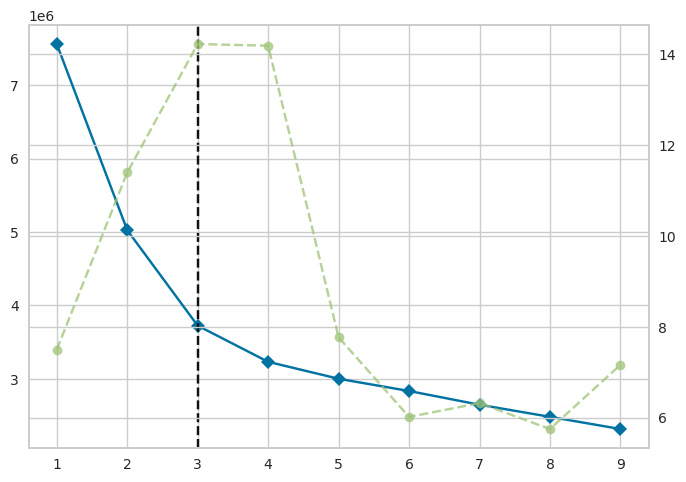

In [29]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

#super()._check_params_vs_input(X, default_n_init=10)
plt.rcParams['font.family'] = 'DejaVu Sans'
elbow_method = KElbowVisualizer(KMeans(n_init=10), k=(1,10))
elbow_method.fit(jointure_cluster)


Le k obtenu se lit au point d'inflexion de la courbe bleue : ici, k=3

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=7, n_init=10)
clusters_kmeans = kmeans.fit_predict(jointure_cluster)


On peut désormais compter le nombre d'éléement dans chacun de nos 3 clusters, en transformant notre sortie clusters_kmeans en un dataframe pour en faciliter le comptage

In [12]:
clusters = pd.DataFrame(clusters_kmeans, columns=['Cluster'])

taille = clusters['Cluster'].value_counts()

taille 

Cluster
1    105783
0     92126
2      6408
Name: count, dtype: int64

In [13]:
from sklearn.decomposition import PCA

nb_composantes_principales = 3

# Effectuer l'ACP
acp = PCA(n_components=nb_composantes_principales)
projection_individus_array = acp.fit_transform(jointure_cluster)
projection_individus = pd.DataFrame(data=projection_individus_array, columns=['PC1', 'PC2', 'PC3'])

# Obtenir les poids des caractéristiques pour chaque composante principale
composantes_principales = pd.DataFrame(acp.components_, columns=data_clustering.columns)


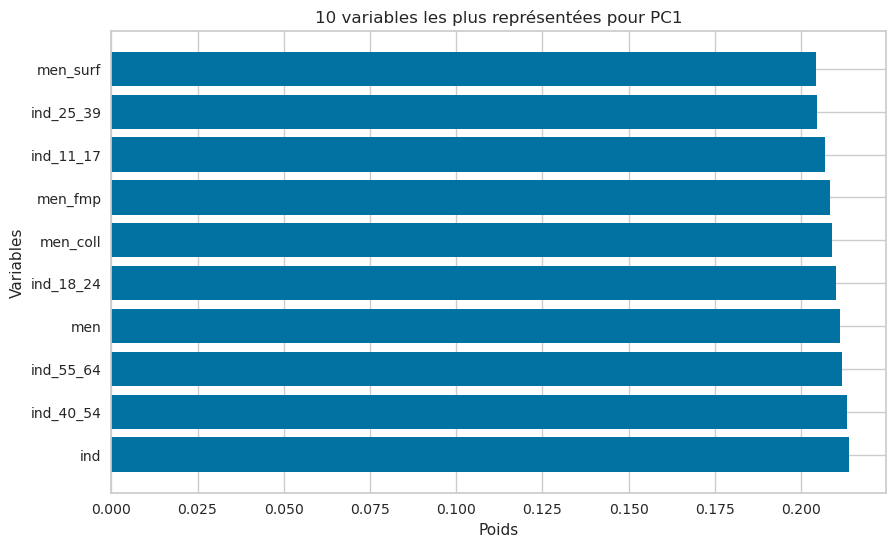

In [21]:
nb_top_features = 10

# Sélectionner les 20 caractéristiques les plus importantes pour PC1
pc1_top_features_abs = composantes_principales.iloc[0].abs().nlargest(nb_top_features, keep='all')
pc1_top_features = composantes_principales.iloc[0].loc[pc1_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC1
plt.rcParams['font.family'] = 'DejaVu Sans' # On remplace la police d'écriture du graphe pour éviter une page d'erreur
plt.figure(figsize=(10, 6))
plt.barh(pc1_top_features.index, pc1_top_features.values)
plt.title(f'{nb_top_features} variables les plus représentées pour PC1')
plt.xlabel('Poids')
plt.ylabel('Variables')
plt.show()

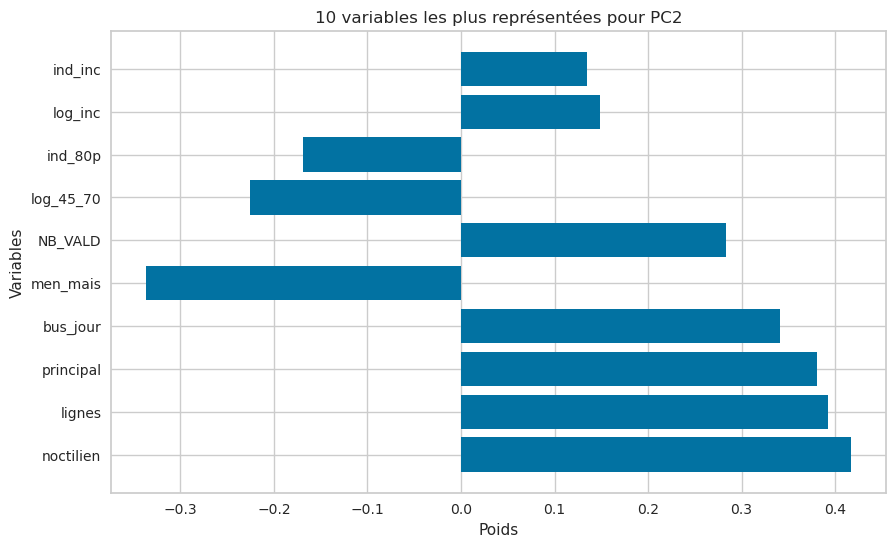

In [20]:
nb_top_features = 10

# Sélectionner les 20 caractéristiques les plus importantes pour PC1
pc2_top_features_abs = composantes_principales.iloc[1].abs().nlargest(nb_top_features, keep='all')
pc2_top_features = composantes_principales.iloc[1].loc[pc2_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC1
plt.rcParams['font.family'] = 'DejaVu Sans' # On remplace la police d'écriture du graphe pour éviter une page d'erreur
plt.figure(figsize=(10, 6))
plt.barh(pc2_top_features.index, pc2_top_features.values)
plt.title(f'{nb_top_features} variables les plus représentées pour PC2')
plt.xlabel('Poids')
plt.ylabel('Variables')
plt.show()

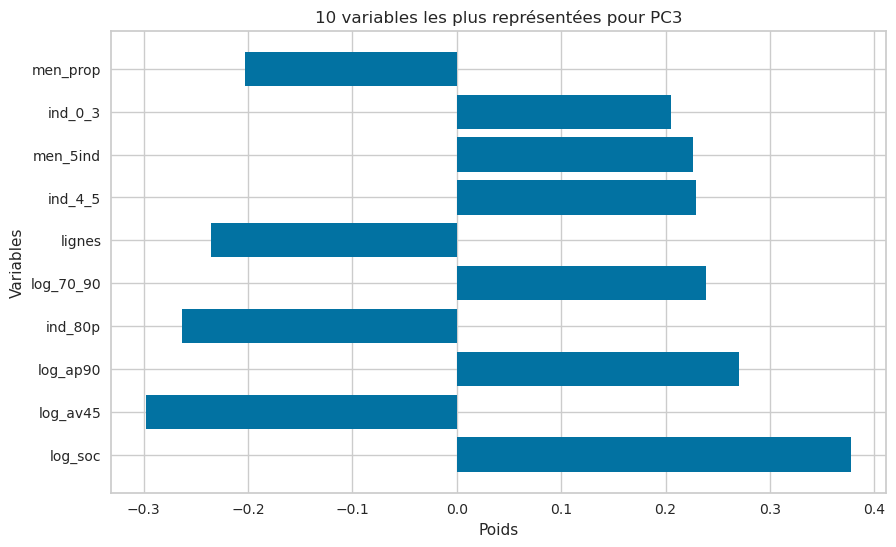

In [22]:
nb_top_features = 10

# Sélectionner les 20 caractéristiques les plus importantes pour PC1
pc3_top_features_abs = composantes_principales.iloc[2].abs().nlargest(nb_top_features, keep='all')
pc3_top_features = composantes_principales.iloc[2].loc[pc3_top_features_abs.index]

# Afficher les poids des caractéristiques pour PC1
plt.rcParams['font.family'] = 'DejaVu Sans' # On remplace la police d'écriture du graphe pour éviter une page d'erreur
plt.figure(figsize=(10, 6))
plt.barh(pc3_top_features.index, pc3_top_features.values)
plt.title(f'{nb_top_features} variables les plus représentées pour PC3')
plt.xlabel('Poids')
plt.ylabel('Variables')
plt.show()

In [25]:
projection_individus_et_clusters = projection_individus.copy()
projection_individus_et_clusters['cluster_kmeans'] = clusters_kmeans
#projection_individus_et_clusters['cluster_cah'] = clusters_cah

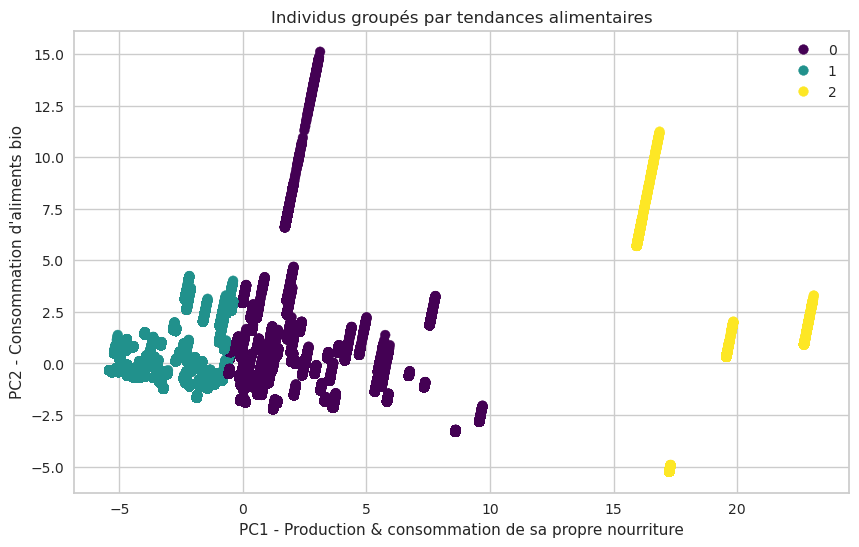

In [27]:
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(
    projection_individus_et_clusters['PC1'],
    projection_individus_et_clusters['PC2'],
    c=projection_individus_et_clusters['cluster_kmeans'],
    cmap='viridis'
)

plt.legend(handles=scatter_plot.legend_elements()[0], labels=range(3))
plt.title('Individus groupés par tendances alimentaires')
plt.xlabel('PC1 - Production & consommation de sa propre nourriture')
plt.ylabel('PC2 - Consommation d\'aliments bio')

plt.show()